# MLP autoencoders

An autoencoder is a network that consists of two main parts:
- an *encoder*, which projects the data into a latent space to transform it into a compact representation.
- a *decoder*, which reconstructs the input data from the latent representation.

In mathematical terms, a data point $\mathbf{x} \in \mathbb{R}^N$ is transformed into a latent representation $\mathbf{z} \in \mathbb{R}^L$, where $L \ll N$. Then, the latent representation is passed to the decoder, which produces an approximation $\hat{\mathbf{x}} \in \mathbb{R}^N$ of the input data, i.e., such that $\hat{\mathbf{x}} \approx \mathbf{x}$.

Autoencoders are very useful in many applications. For instance, in image processing, they are used for image denoising, compression, and generative models (image synthesis and transformation). They can also be used for transfer learning: first an autoencoder is trained to learn a latent representation of the data, and then this representation can be used for other classification/regression tasks.

<center><a href="https://emkademy.medium.com/1-first-step-to-generative-deep-learning-with-autoencoders-22bd41e56d18">
    <img src="https://miro.medium.com/max/772/1*ztZn098tDQsnD5J6v1eNuQ.png" width="600"></a></center>


In [800]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import numpy as np
import matplotlib.pyplot as plt
import copy


## Dataset

In [801]:
# Define the data repository
data_dir = 'data/'

# Load the MNIST dataset
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(400))

# We define the train and validation sets and dataloaders as in the previous script
n_train_examples = int(len(train_data)*0.8)
n_valid_examples = len(train_data) - n_train_examples
torch.manual_seed(0)
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples])

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(test_data, batch_size=batch_size)

In [802]:
# Get a batch of images from the train dataloader (no need for the labels here)
image_batch_example = next(iter(train_dataloader))[0]
print(image_batch_example.shape)

torch.Size([8, 1, 28, 28])


## The encoder

First, let us write the encoder. We consider a 3-layer encoder, where each layer consists of a Linear part and a ReLU activation function. The first layer goes from size `input_size` to 128, the second layer from 128 to 64, and the third layer from 64 to 32.

In [803]:
# TO DO: write the encoder class ('__init__' and 'forward' methods)
class MLPClassif_Encoder(nn.Module):
    def __init__(self, input_size):
        super(MLPClassif_Encoder, self).__init__()
        self.input_layer = nn.Sequential(nn.Linear(input_size, 128), nn.ReLU())
        self.hidden_layer = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.output_layer = nn.Sequential(nn.Linear(64, 32), nn.ReLU())

    def forward(self, x):
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        out = self.output_layer(y)
        return out

In [804]:
# TO DO:
# - instanciate an encoder (get the proper input size)
vectorized_batch = image_batch_example.view(batch_size, -1)
input_size = vectorized_batch.shape[-1]
model_encoding = MLPClassif_Encoder(input_size)
# - vectorize image_batch_example into image_batch_example_vec
image_batch_example_vec = image_batch_example.view(batch_size, -1)
# - apply the encoder to image_batch_example_vec to produce the latent representation 'z'
z = model_encoding(image_batch_example_vec)
# - print the size of z, and the size of the image_batch_example_vec
print(z.shape)

torch.Size([8, 32])


In [805]:
input_size

784

You can see that the latent representation has a significantly smaller dimension than the original data (vectorized image).


## The decoder

The decoder as a similar structure than the encoder (3 {Linear + activation} layers) but the sizes are flipped: the first layer goes from 32 to 64, the second layer goes from 64 to 128, and the last layer goest from 128 back to the input size. The first and second layers use a ReLU activation, but the last layer uses a Sigmoid: this forces the output to be in the range $[0,1]$, which corresponds to the normalized images.

In [806]:
# TO DO: write the decoder class ('__init__' and 'forward' methods)
class MLPClassif_Decoder(nn.Module):
    def __init__(self, input_size):
        super(MLPClassif_Decoder, self).__init__()
        self.input_layer = nn.Sequential(nn.Linear(32, 64), nn.ReLU())
        self.hidden_layer = nn.Sequential(nn.Linear(64, 128), nn.ReLU())
        self.output_layer = nn.Sequential(nn.Linear(128, input_size),nn.Sigmoid())

    def forward(self, x):
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        out = self.output_layer(y)
        return out

In [807]:
# TO DO:
# - instanciate a decoder
model_decoding = MLPClassif_Decoder(input_size)
# - apply it to the latent representation z computed before
y = model_decoding(z)
# - print the size of the output 'y' of the decoder : it should be the same as the input data 'image_batch_example_vec'
print(y.shape)

torch.Size([8, 784])


## The autoencoder main module

Finally we can write the autoencoder module: it consists of the encoder and the decoder applied sequentially.

In [808]:
# TO DO: write the MLP autoencoder class using the previously written encoder and decoder classes
class MLPClassif_Autocoder(nn.Module):
    def __init__(self, input_size):
        super(MLPClassif_Autocoder, self).__init__()
        # Create instances of MLPClassif_Decoder and MLPClassif_Encoder
        self.encoder = MLPClassif_Encoder(input_size)
        self.decoder = MLPClassif_Decoder(input_size)

    def forward(self, x):
        y = self.encoder(x)
        out = self.decoder(y)
        return out

In [809]:
# TO DO: Instanciate an MLP autoencoder and print the number of parameters.
model = MLPClassif_Autocoder(input_size)

# A useful command to get the total number of parameters in the model
print('Total number of parameters:', sum(p.numel() for p in model.parameters()))

Total number of parameters: 222384


In [810]:
# initialization (ensure reproducibility: everybody should have the same results)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

torch.manual_seed(0)
model.apply(init_weights)

MLPClassif_Autocoder(
  (encoder): MLPClassif_Encoder(
    (input_layer): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU()
    )
    (hidden_layer): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (output_layer): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (decoder): MLPClassif_Decoder(
    (input_layer): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
    )
    (hidden_layer): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
    )
    (output_layer): Sequential(
      (0): Linear(in_features=128, out_features=784, bias=True)
      (1): Sigmoid()
    )
  )
)

In [811]:
# A useful command to get the total number of parameters in the model
print('Total number of parameters:', sum(p.numel() for p in model.parameters()))

Total number of parameters: 222384


<span style="color:red">**Q3**</span> How many parameters are in the autoencoder?

## Training

Now we can write the training function (with validation !). It's very similar to the training function for the MLP classifier from the previous script, up to two main differences:
- since we don't try to predict a label, we don't need to load them when iterating over the dataloader.
- the loss function is no longer Cross Entropy (which is for classification), but [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html?highlight=mse#torch.nn.MSELoss) (*cf.* lab 2).

Regarding the loss, remember that the autoencoder tries to compress the input data (through the encoder) and then produce an approximation of this input data (through the decoder). This means that the input and output of the decoder should have the same dimension, and the loss is computed between these two quantities: $\mathcal{L}(\hat{\mathbf{x}}, \mathbf{x})$.

Finally, unlike in lab 4.1, since here we evaluate the model on the validation set by computing the loss (and not the accuracy), be careful that it should be decreasing (instead of increasing).

In [812]:
# Evaluation function
def eval_mlp_classifier(model, eval_dataloader, loss_fn):

    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval()

     # Initialize a list with the loss for batches
    losses = []

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():

        # Iterate over the dataset using the dataloader
        for images, _ in eval_dataloader:

            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            images_predicted = model(images)

            # Get the loss
            loss = loss_fn(images_predicted,images)
            losses.append(loss.item())

    accuracy = np.mean(losses)

    return accuracy

In [813]:
# TO DO: write the autoencoder training function with validation (also write the evaluation function)
def train_val_mlp_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)

    # Set the model in 'training' mode (ensures all parameters' gradients are computed)
    model_tr.train()

    # define the optimizer (ADAM)
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)

    # Initialize a list to save the training loss over epochs
    loss_all_epochs = []

    # Initialize a list to save the accuracy over epochs
    accuracy =[]

    # Training loop
    for epoch in range(num_epochs):
        loss_current_epoch = 0

        # Iterate over batches (here we don't need labels
        for batch, (images, _) in enumerate(train_dataloader):

            # vectorize the images
            images_vectorized = images.reshape(images.shape[0], -1)

            # forward pass
            images_predicted = model_tr(images_vectorized)
            loss = loss_fn(images_predicted, images_vectorized)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            loss_current_epoch += loss.item()
        # At the end of each epoch, record the loss over all batches
        loss_all_epochs.append(loss_current_epoch)

        # At the end of each epoch, get the accuracy and store it
        evalIJS = eval_mlp_classifier(model_tr,valid_dataloader, loss_fn)
        accuracy.append(evalIJS)

        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, loss, evalIJS))

    return model_tr, loss_all_epochs, accuracy

In [814]:
# TO DO:
# - Train the autoencoder: 50 epochs, learning rate = 0.001, and MSE loss function
# - After training, save the model parameters and plot the loss over epochs
loss_fn = nn.MSELoss()
num_epochs = 50
learning_rate = 0.001
model_opt, train_losses, val_accuracies = train_val_mlp_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/50], Training loss: 0.9121, Accuracy: 0.8191
Epoch [2/50], Training loss: 0.7630, Accuracy: 0.7743
Epoch [3/50], Training loss: 0.6836, Accuracy: 0.7310
Epoch [4/50], Training loss: 0.7447, Accuracy: 0.7001
Epoch [5/50], Training loss: 0.6277, Accuracy: 0.6849
Epoch [6/50], Training loss: 0.5938, Accuracy: 0.6761
Epoch [7/50], Training loss: 0.6897, Accuracy: 0.6633
Epoch [8/50], Training loss: 0.5589, Accuracy: 0.6528
Epoch [9/50], Training loss: 0.5114, Accuracy: 0.6510
Epoch [10/50], Training loss: 0.5966, Accuracy: 0.6464
Epoch [11/50], Training loss: 0.5431, Accuracy: 0.6414
Epoch [12/50], Training loss: 0.7014, Accuracy: 0.6424
Epoch [13/50], Training loss: 0.5501, Accuracy: 0.6391
Epoch [14/50], Training loss: 0.5800, Accuracy: 0.6391
Epoch [15/50], Training loss: 0.5328, Accuracy: 0.6389
Epoch [16/50], Training loss: 0.5995, Accuracy: 0.6348
Epoch [17/50], Training loss: 0.5238, Accuracy: 0.6351
Epoch [18/50], Training loss: 0.5735, Accuracy: 0.6346
Epoch [19/50], Trai

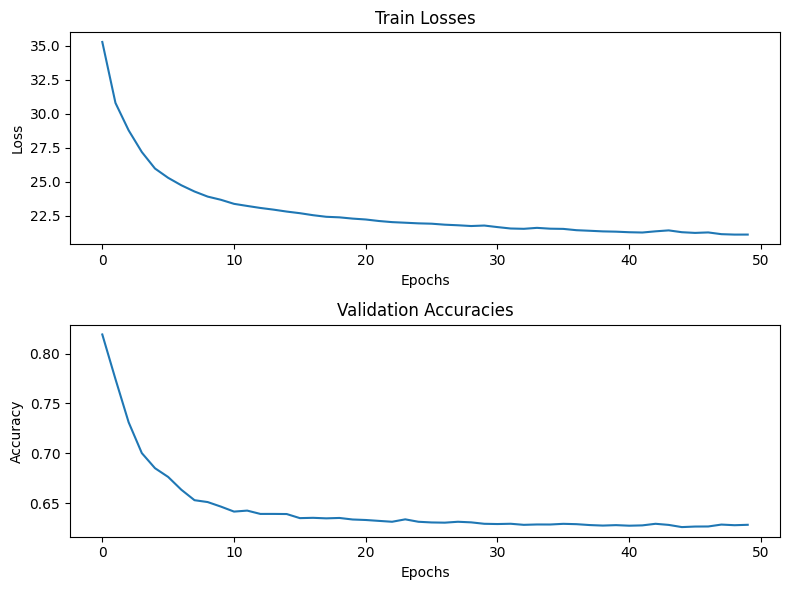

In [815]:
# - Print the test accuracy
# Create a single figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot the first graph on the first subplot
ax1.plot(train_losses)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Train Losses')

# Plot the second graph on the second subplot
ax2.plot(val_accuracies)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracies')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined graph
plt.show()

## Test and visualization

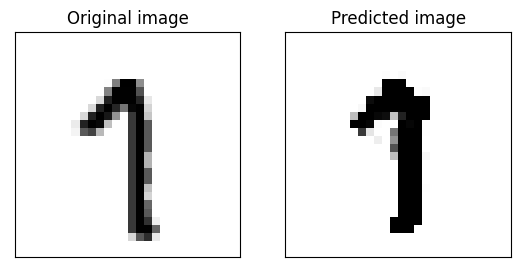

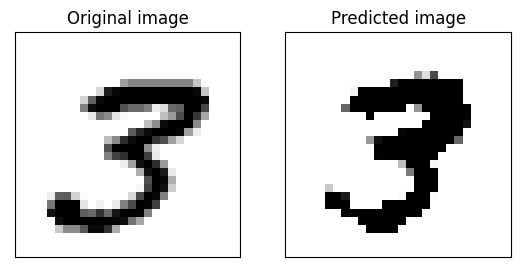

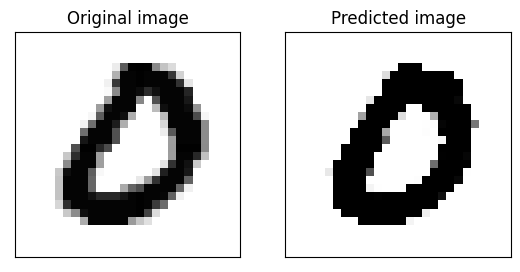

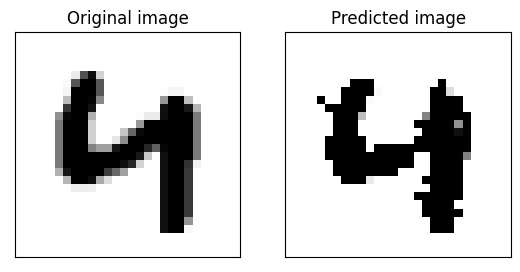

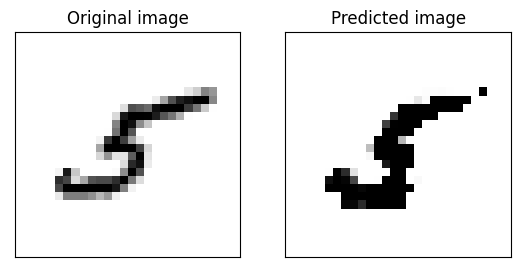

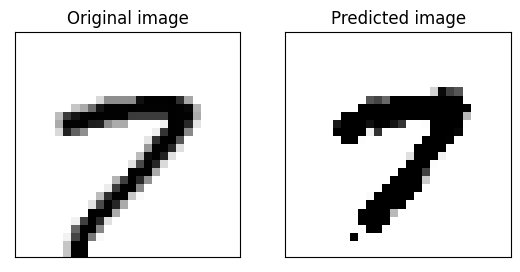

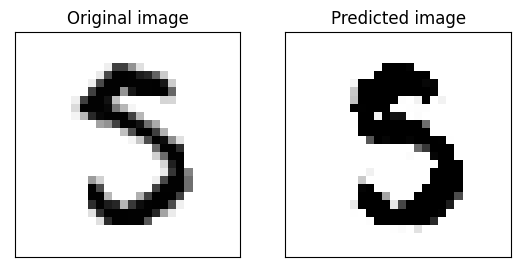

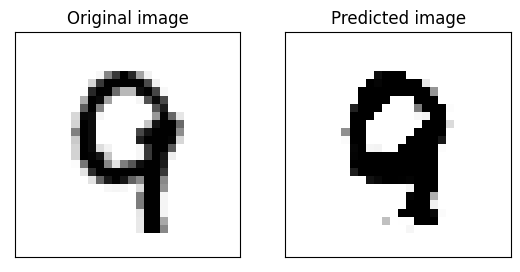

In [816]:
# Apply the autoencoder to the image_batch_example
predicted_batch_example = model_opt(image_batch_example_vec).detach()

# # Reshape the output of the decoder to a 2D tensor (batch_size, 1*28*28)
# predicted_batch_example = predicted_batch_example.view(batch_size, 1 * 28 * 28)
#
# # Expand the 2D tensor to the desired shape (batch_size, 1, 28, 28)
# predicted_batch_example  = predicted_batch_example .reshape(batch_size, 1, 28, 28)

# Reshape it as a black-and-white image (3D tensor)
predicted_batch_example = predicted_batch_example.reshape(batch_size, 1, 28, 28)

# Plot the original and predicted images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Predicted image')
    plt.show()

<span style="color:red">**Q4**</span> In your report, put the plot with the training/validation losses, and one of the plots above (one original image and its corresponding estimation).